<center>
    <h1>
        term identification system for a specific domain
    </h1>
    Rameez Qurashi, Abdelhak Zabour
    </center>
    

In [28]:
# PhraseMatcher.py
# import necessary modules

from __future__ import unicode_literals, print_function


from pathlib import Path
from spacy.util import minibatch, compounding
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy import displacy
from collections import Counter
from spacy.matcher import PhraseMatcher #import PhraseMatcher class
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
from time import sleep
from progressbar import progressbar
from spacy.tokens import Span
from spacy.util import minibatch, compounding
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import random
import plac
import warnings
import pandas as pd
import numpy as np
import xlrd
import spacy
import en_core_web_sm
import json 
import re

plt.rcParams["figure.figsize"] = (15,10)

nltk.download('punkt')

# Language class with the English model 'en_core_web_sm' is loaded
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 7000000

[nltk_data] Downloading package punkt to /Users/abdelhak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:

def train_spacy(data, n_iter = 10, load = False, train = False):
    
    if train:
        TRAIN_DATA = data
        # load space model
        if load:
            nlp = spacy.load("en_core_web_sm")
        else:
            nlp = spacy.blank('en')



        if "ner" not in nlp.pipe_names:
            ner = nlp.create_pipe("ner")
            nlp.add_pipe(ner, last=True)
        else:
            ner = nlp.get_pipe("ner")

        # add labels
        # for _, annotations in TRAIN_DATA:
        #      for ent in annotations.get('entities'):
        ner.add_label('AstroTerm')
        # get names of other pipes to disable them during training
        other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

        # Resume training
        #optimizer = nlp.resume_training()
        #move_names = list(ner.move_names)

        nlp.begin_training()

        # Begin training by disabling other pipeline components
        with nlp.disable_pipes(*other_pipes):
            # show warnings for misaligned entity spans once
            optimizer = nlp.begin_training()

            sizes = compounding(1.0, 5.0, 1.001)
            # Training for n_iter iterations     
            for itn in progressbar(range(n_iter)):
                sleep(0.02)
            # shuffle examples before training
                random.shuffle(TRAIN_DATA)
                # batch up the examples using spaCy's minibatch
                batches = minibatch(TRAIN_DATA, size=sizes)
                # dictionary to store losses
                losses = {}
                for batch in batches:
                    texts, annotations = zip(*batch)
                    # Calling update() over the iteration
                    nlp.update(texts, annotations, sgd=optimizer, drop=0.25, losses=losses)
                    #print("Losses", losses)
                    
        output_dir = "output_dir"
        if output_dir is not None:
            output_dir = Path(output_dir)
            if not output_dir.exists():
                output_dir.mkdir()
            nlp.to_disk(output_dir)
            print("Saved model to", output_dir)
            
        return nlp
    else:
        return 0

    
    
def extract_entities(doc):
    dict_new_ents = {}
    list_new_ents = []
    for ent in doc.ents:
        # Only check
        if ent.label_ == "AstroTerm":
            
            
            list_new_ents.append((ent.start_char, ent.end_char, ent.label_))      
    
    dict_new_ents['entities'] = list_new_ents
            
    return (doc.text,dict_new_ents )


## Read the list of terminology 

In [13]:
terms_corpus = pd.read_excel('astronomy.xls')

In [14]:
# the list containing the pharses to be matched
terminology_list = []
for term in terms_corpus['key']:
    terminology_list.append(term[term.find(':')+2:])

## text for training:

In [15]:
# import glob
# read_files = glob.glob("corpus/Astromony_*.txt")
# with open("corpus/result.txt", "wb") as outfile:
#     for f in read_files:
#         with open(f, "rb") as infile:
#             outfile.write(infile.read())

# the input text string is converted to a Document object

file = open('corpus/result.txt')
text = file.read()

## Entity ruler

In [16]:
nlp_rule_based = English()
ruler = EntityRuler(nlp_rule_based)

In [17]:
# create patterns
patterns = []

for term in terminology_list:
    dct = {}
    temp = term.split()
    if len(temp) == 1:
        dct["label"] = "AstroTerm"
        dct["pattern"] = temp[0]
        patterns.append(dct)
    else:
        lst = []
        for item in temp:
            dct_temp = {}
            dct_temp["lower"] = item
            
            lst.append(dct_temp)
            
        dct["label"] = "AstroTerm"
        dct["pattern"] = lst
        patterns.append(dct)

In [18]:
# add patterns and pipe
ruler.add_patterns(patterns)
nlp_rule_based.add_pipe(ruler)

In [19]:
# generate annotaeted data
train_data = []
for doc in nltk.tokenize.sent_tokenize(text):
    doc = nlp_rule_based(doc)
    train_data.append(extract_entities(doc))

## Neural Network approach:

In [20]:
# to train the model set 'train' to true 
nlp = train_spacy(train_data, 100, train = False)

In [21]:
# save the model
#output_dir = "output_dir"
# if output_dir is not None:
#     output_dir = Path(output_dir)
#     if not output_dir.exists():
#         output_dir.mkdir()
#     nlp.to_disk(output_dir)
#     print("Saved model to", output_dir)

In [22]:
# upload the saved model
output_dir = "output_dir"
print("Loading from", output_dir)
nlp = spacy.load(output_dir)

Loading from output_dir


In [23]:
# text test
text_test = input("Enter your testing text: ")

Enter your testing text: Enter your testing text: "These Hubble images may be snapshots of what present-day dwarf galaxies may have been like at earlier epochs," said lead researcher Erik Tollerud of the Space Telescope Science Institute in Baltimore, Maryland. "Studying these and other similar galaxies can provide further clues to dwarf galaxy formation and evolution."  The Hubble observations suggest that the galaxies, called Pisces A and B, are late bloomers because they have spent most of their existence in the Local Void, a region of the universe sparsely populated with galaxies. The Local Void is roughly 150 million light-years across.  Under the steady pull of gravity from the galactic big city, the loner dwarf galaxies have at last entered a crowded region that is denser in intergalactic gas. In this gas-rich environment, star birth may have been triggered by gas raining down on the galaxies as they plow through the denser region. Another idea is that the duo may have encounter

In [53]:
# test text
#file = open('test_corpus/text09.txt')
#text_test = file.read()

In [24]:
# run the neural network model
doc = nlp(text_test)
entities = [(ent.text, ent.label_) for ent in doc.ents]
#print("Entities", entities)
counter_nn = Counter(entities)
counter_nn

Counter({('Space Telescope', 'AstroTerm'): 1,
         ('dwarf galaxy', 'AstroTerm'): 1,
         ('universe', 'AstroTerm'): 3,
         ('light', 'AstroTerm'): 4,
         ('gravity', 'AstroTerm'): 1,
         ('star', 'AstroTerm'): 4,
         ('gaseous', 'AstroTerm'): 1,
         ('filament', 'AstroTerm'): 2,
         ('galaxy', 'AstroTerm'): 5,
         ('empty', 'AstroTerm'): 1,
         ('space', 'AstroTerm'): 1,
         ('hydrogen', 'AstroTerm'): 3,
         ('star formation', 'AstroTerm'): 4,
         ('neighborhood', 'AstroTerm'): 1,
         ('faint', 'AstroTerm'): 1,
         ('hydrogen gas', 'AstroTerm'): 1,
         ('WIYN telescope', 'AstroTerm'): 1,
         ('telescope', 'AstroTerm'): 1,
         ('trace', 'AstroTerm'): 1,
         ('Panoramic Survey', 'AstroTerm'): 1,
         ('System survey', 'AstroTerm'): 1,
         ('wide-survey', 'AstroTerm'): 1,
         ('radio telescope', 'AstroTerm'): 1})

In [25]:
# run rule based model
doc = nlp_rule_based(text_test)
entities = [(ent.text, ent.label_) for ent in doc.ents]
#print("Entities", entities)
counter = Counter(entities)
counter

Counter({('Space Telescope', 'AstroTerm'): 1,
         ('dwarf galaxy', 'AstroTerm'): 1,
         ('universe', 'AstroTerm'): 3,
         ('light', 'AstroTerm'): 4,
         ('gravity', 'AstroTerm'): 1,
         ('star', 'AstroTerm'): 4,
         ('gaseous', 'AstroTerm'): 1,
         ('filament', 'AstroTerm'): 2,
         ('galaxy', 'AstroTerm'): 5,
         ('empty', 'AstroTerm'): 1,
         ('space', 'AstroTerm'): 1,
         ('hydrogen', 'AstroTerm'): 3,
         ('star formation', 'AstroTerm'): 4,
         ('neighborhood', 'AstroTerm'): 1,
         ('faint', 'AstroTerm'): 1,
         ('hydrogen gas', 'AstroTerm'): 1,
         ('telescope', 'AstroTerm'): 2,
         ('trace', 'AstroTerm'): 1,
         ('radio telescope', 'AstroTerm'): 1})

In [86]:
#displacy.render(matched_sents, style="ent", manual=True)


In [26]:

terms_nn = [[ter, val] for ter, val in zip(counter_nn.keys(),counter_nn.values())]
terms_RB = [[ter, val] for ter, val in zip(counter.keys(),counter.values())]


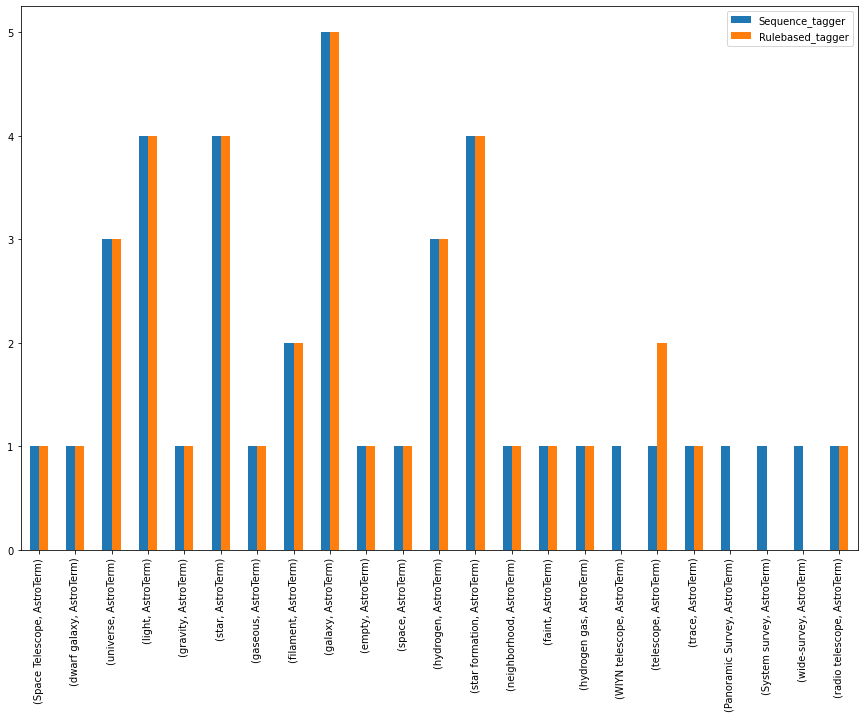

In [40]:
dfs = [pd.DataFrame(np.array(lst), 
                    columns=['idx', i]).set_index('idx')
          for i,lst in zip(['Sequence_tagger', 'Rulebased_tagger'],[terms_nn,terms_RB])]

df = pd.concat(dfs, axis=1)

ax = df.plot.bar()